# Getting Started: Hybrid Renewable Energy Forecasting and Trading Competition

This notebook is a quick start guide intended to help participants get going
quickly, to support understanding of the data and tasks, and to provide a 
transparent benchmark method that will feature in the competition leaderboard.


## Requirements
First, let's load some useful packages for working with the energy and weather
data we'll need for the competition tasks.

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.iolib.smpickle import load_pickle

import comp_utils

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pickle as pkl

## Generate a competition submission

So far we have loaded historic data and fit models to predict the total wind 
and solar power generation. Now we'll look at how to retrieve the latest
weather forecast and submit our forecasts and market bids to the competition
platform.

The steps are as follows:

1. Retrieve the latest weather forecasts via the competition API
2. Calculate the features we need as inputs to our models
3. Generate our forecasts using the saved models
4. Wrangle our forecasts and market bids into the necessary format for submission
5. Submit via API!

These are the steps carried out in `auto_submitter.py`, which illustrates
how the process may be automated (see `README`).

This example is based on energy forecasting only, the market bid we'll submit
will be equal to the 50% quantile forecast. You might like to develop a more
sophisticated trading strategy using additional data and forecast of prices.
The competition API provides access to relevant data from the GB electricity
market, and you may make use of any other data you like as well. 

The `comp_utils` module includes an client to help access the API endpoints. We'll
use them to download the data and another function from `comp_utlis` to the response to `xarray` format to match the historic data we've used already. First, we need to set-up the client.

In [2]:
rebase_api_client = comp_utils.RebaseAPI(api_key = open("team_key.txt").read()[:-1])

In [46]:
# rebase_api_client.get_variable(day='2024-04-09', variable="day_ahead_price")

In [3]:
latest_dwd_Hornsea1 = comp_utils.weather_df_to_xr(rebase_api_client.get_hornsea_dwd())
latest_ncep_Hornsea1 = comp_utils.weather_df_to_xr(rebase_api_client.get_hornsea_gfs())

latest_dwd_solar = comp_utils.weather_df_to_xr(rebase_api_client.get_pes10_nwp("DWD_ICON-EU"))
latest_ncep_solar = comp_utils.weather_df_to_xr(rebase_api_client.get_pes10_nwp("NCEP_GFS"))

200
200
200
200


In [5]:
# latest_ncep_Hornsea1
latest_dwd_Hornsea1

<xarray.Dataset>
Dimensions:             (ref_datetime: 1, valid_datetime: 93, longitude: 6,
                         latitude: 6)
Coordinates:
  * ref_datetime        (ref_datetime) object 1715407200000000000
  * valid_datetime      (valid_datetime) object 1715407200000000000 ... 17158...
  * longitude           (longitude) object '1.702' '1.767' ... '1.962' '2.027'
  * latitude            (latitude) object '53.77' '53.84' ... '54.03' '54.1'
Data variables:
    PressureReducedMSL  (ref_datetime, valid_datetime, longitude, latitude) float64 ...
    RelativeHumidity    (ref_datetime, valid_datetime, longitude, latitude) float64 ...
    Temperature         (ref_datetime, valid_datetime, longitude, latitude) float64 ...
    WindDirection       (ref_datetime, valid_datetime, longitude, latitude) float64 ...
    WindDirection:100   (ref_datetime, valid_datetime, longitude, latitude) float64 ...
    WindSpeed           (ref_datetime, valid_datetime, longitude, latitude) float64 ...
    WindSpeed:100       (ref_datetime, valid_datetime, longitude, latitude) float64 ...

* 매일매일 업데이트 되는 예보데이터 및 태양광/풍력 데이터 저장하기 (23.12.14 ~ 진행 중)
    * Note: 한국 시간으로 오후 5시 반 이후에 긁어오기!!

In [5]:
latest_dwd_Hornsea1.to_dataframe().to_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\dwd_icon_eu_hornsea_1_20231229_raw.csv")
latest_ncep_Hornsea1.to_dataframe().to_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\ncep_gfs_hornsea_1_20231229_raw.csv")
latest_dwd_solar.to_dataframe().to_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\dwd_icon_pes10_20231229_raw.csv")
latest_ncep_solar.to_dataframe().to_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\ncep_gfs_pes10_20231229_raw.csv")

* API로 긁어온 raw data 후처리

In [7]:
latest_dwd_Hornsea1 = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\updated_weather_forecast_data\raw_format\dwd_icon_eu_hornsea_1_2024518_0_raw.csv", index_col=0)
# latest_ncep_Hornsea1 = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\updated_weather_forecast_data\raw_format\ncep_gfs_hornsea_1_2024518_0_raw.csv", index_col=0)
latest_dwd_solar = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\updated_weather_forecast_data\raw_format\dwd_icon_pes10_2024518_0_raw.csv", index_col=0)
# latest_ncep_solar = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\updated_weather_forecast_data\raw_format\ncep_gfs_pes10_2024518_0_raw.csv", index_col=0)


In [8]:
latest_dwd_Hornsea1_features = pd.DataFrame(columns=latest_dwd_Hornsea1.columns, data=np.zeros((int(latest_dwd_Hornsea1.shape[0]/36), latest_dwd_Hornsea1.shape[1])))
latest_dwd_Hornsea1_features.drop(columns=['longitude', 'latitude'], inplace=True)
# latest_ncep_Hornsea1_features = pd.DataFrame(columns=latest_ncep_Hornsea1.columns, data=np.zeros((int(latest_ncep_Hornsea1.shape[0]/9), latest_ncep_Hornsea1.shape[1])))
# latest_ncep_Hornsea1_features.drop(columns=['longitude', 'latitude'], inplace=True)

for i in range(int(latest_dwd_Hornsea1.shape[0]/36)):
    avg = latest_dwd_Hornsea1.iloc[36*i:36*(i+1),4:].mean()
    time_idx = latest_dwd_Hornsea1.iloc[36*i:36*(i+1),:2].values[0]

    latest_dwd_Hornsea1_features.loc[i,avg.keys()] = avg.values
    latest_dwd_Hornsea1_features.iloc[i,:2] = time_idx

# for i in range(int(latest_ncep_Hornsea1.shape[0]/9)):
#     avg = latest_ncep_Hornsea1.iloc[9*i:9*(i+1),4:].mean()
#     time_idx = latest_ncep_Hornsea1.iloc[9*i:9*(i+1),:2].values[0]

#     latest_ncep_Hornsea1_features.loc[i,avg.keys()] = avg.values
#     latest_ncep_Hornsea1_features.iloc[i,:2] = time_idx

##############################################################################################################

latest_dwd_solar_features = pd.DataFrame(columns=latest_dwd_solar.columns, data=np.zeros((int(latest_dwd_solar.shape[0]/20), latest_dwd_solar.shape[1])))
latest_dwd_solar_features.drop(columns=['point', 'longitude', 'latitude'], inplace=True)
# latest_ncep_solar_features = pd.DataFrame(columns=latest_ncep_solar.columns, data=np.zeros((int(latest_ncep_solar.shape[0]/20), latest_ncep_solar.shape[1])))
# latest_ncep_solar_features.drop(columns=['point', 'longitude', 'latitude'], inplace=True)

for i in range(int(latest_dwd_solar.shape[0]/20)):
    avg = latest_dwd_solar.iloc[20*i:20*(i+1),3:-2].mean()
    time_idx = latest_dwd_solar.iloc[20*i:20*(i+1),:2].values[0]

    latest_dwd_solar_features.loc[i,avg.keys()] = avg.values
    latest_dwd_solar_features.iloc[i,:2] = time_idx

# for i in range(int(latest_ncep_solar.shape[0]/20)):
#     avg = latest_ncep_solar.iloc[20*i:20*(i+1),3:-2].mean()
#     time_idx = latest_ncep_solar.iloc[20*i:20*(i+1),:2].values[0]

#     latest_ncep_solar_features.loc[i,avg.keys()] = avg.values
#     latest_ncep_solar_features.iloc[i,:2] = time_idx

##############################################################################################################

latest_forecast_table = latest_dwd_Hornsea1_features.merge(latest_dwd_solar_features,how="inner",on=["ref_datetime","valid_datetime"])
latest_forecast_table.valid_datetime = pd.DatetimeIndex(latest_forecast_table.valid_datetime)
latest_forecast_table.ref_datetime = pd.DatetimeIndex(latest_forecast_table.ref_datetime)
latest_forecast_table = latest_forecast_table.set_index("valid_datetime").resample("30T").interpolate("linear",limit=5).reset_index()

# latest_forecast_table = latest_ncep_Hornsea1_features.merge(latest_ncep_solar_features,how="inner",on=["ref_datetime","valid_datetime"])
# latest_forecast_table.valid_datetime = pd.DatetimeIndex(latest_forecast_table.valid_datetime)
# latest_forecast_table.ref_datetime = pd.DatetimeIndex(latest_forecast_table.ref_datetime)
# # latest_forecast_table_ = latest_forecast_table_[latest_forecast_table_["ref_datetime"] < "2023-12-23 00:00:00"] # modify this!!

latest_forecast_table = latest_forecast_table.dropna()
latest_forecast_table = latest_forecast_table.set_index("valid_datetime").resample("30T").interpolate("linear",limit=5).reset_index()

In [9]:
latest_forecast_table

,valid_datetime,ref_datetime,PressureReducedMSL_x,RelativeHumidity,Temperature_x,TotalPrecipitation_x,WindDirection,WindDirection:100,WindSpeed,WindSpeed:100,SolarDownwardRadiation,TotalPrecipitation_y,CloudCover,Temperature_y,PressureReducedMSL_y
0,2024-05-18 01:00:00+00:00,2024-05-18 00:00:00+00:00,101254.911458,94.273547,12.125817,0.000000,293.999208,67.053475,3.642254,6.122238,0.00,0.0,1.000,11.330,101298.270000
1,2024-05-18 01:30:00+00:00,2024-05-18 00:00:00+00:00,101251.203993,94.295812,12.143082,0.000000,274.906360,44.044495,3.637496,6.126928,0.00,0.0,0.995,11.405,101302.715000
2,2024-05-18 02:00:00+00:00,2024-05-18 00:00:00+00:00,101247.496528,94.318078,12.160346,0.000000,255.813511,21.035514,3.632739,6.131617,0.00,0.0,0.990,11.480,101307.160000
3,2024-05-18 02:30:00+00:00,2024-05-18 00:00:00+00:00,101224.090278,94.321224,12.158181,0.000353,227.597478,18.491791,3.604304,6.064073,0.00,0.0,0.990,11.670,101291.625000
4,2024-05-18 03:00:00+00:00,2024-05-18 00:00:00+00:00,101200.684028,94.324370,12.156016,0.000705,199.381445,15.948068,3.575869,5.996528,0.00,0.0,0.990,11.860,101276.090000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,2024-05-22 21:30:00+00:00,2024-05-18 00:00:00+00:00,100608.994068,96.396696,12.292608,0.583008,315.820286,322.313736,8.379213,11.510740,3.14,0.0,1.000,14.655,100879.911667
234,2024-05-22 22:00:00+00:00,2024-05-18 00:00:00+00:00,100599.174769,96.436875,12.268907,0.583008,314.244944,320.489363,8.575288,11.749322,3.14,0.0,1.000,14.620,100881.553333
235,2024-05-22 22:30:00+00:00,2024-05-18 00:00:00+00:00,100589.355469,96.477053,12.245207,0.583008,312.669601,318.664989,8.771363,11.987905,3.14,0.0,1.000,14.585,100883.195000
236,2024-05-22 23:00:00+00:00,2024-05-18 00:00:00+00:00,100579.536169,96.517231,12.221507,0.583008,311.094259,316.840615,8.967439,12.226488,3.14,0.0,1.000,14.550,100884.836667


In [10]:
latest_forecast_table.to_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\dwd_icon_eu_weather_forecast_for_wind_solar_20240518_0.csv")
# latest_forecast_table.to_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\ncep_gfs_weather_forecast_for_wind_solar_20240518_0.csv")

# latest_forecast_table_.to_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\ncep_gfs_weather_forecast_for_wind_solar_20231231_6.csv")

In [15]:
# 에너지 데이터 
# rebase_api_client.get_variable(day="2024-04-04", variable="wind_total_production")
# .to_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main/wind_mv_2024-04-04.csv")

# rebase_api_client.get_variable(day="2023-12-14", variable="solar_total_production").to_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main/solar_mv_2023-12-24_1.csv")
rebase_api_client.get_variable(day="2024-04-24", variable="solar_total_production").to_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main/solar_mv_2024-04-24.csv")

And then calculate our weather features and  merge the wind and solar data as before...

In [9]:
# latest_dwd_Hornsea1_features = latest_dwd_Hornsea1["WindSpeed:100"].mean(dim=["latitude","longitude"]).to_dataframe().reset_index()
latest_dwd_Hornsea1_features = latest_dwd_Hornsea1[["WindSpeed:100", "WindSpeed", "WindDirection:100", "WindDirection", "Temperature", "RelativeHumidity", "PressureReducedMSL"]].mean(dim=["latitude","longitude"]).to_dataframe().reset_index()
latest_ncep_Hornsea1_features = latest_ncep_Hornsea1[["WindSpeed:100", "WindSpeed", "WindDirection:100", "WindDirection", "Temperature", "RelativeHumidity", "PressureReducedMSL"]].mean(dim=["latitude","longitude"]).to_dataframe().reset_index()


# latest_dwd_solar_features = latest_dwd_solar["SolarDownwardRadiation"].mean(dim="point").to_dataframe().reset_index()
latest_dwd_solar_features = latest_dwd_solar[["SolarDownwardRadiation", "CloudCover", "Temperature", "TotalPrecipitation"]].mean(dim="point").to_dataframe().reset_index()
latest_ncep_solar_features = latest_ncep_solar[["SolarDownwardRadiation", "CloudCover", "Temperature", "TotalPrecipitation"]].mean(dim="point").to_dataframe().reset_index()

latest_forecast_table = latest_dwd_Hornsea1_features.merge(latest_dwd_solar_features,how="inner",on=["ref_datetime","valid_datetime"])
latest_forecast_table = latest_forecast_table.set_index("valid_datetime").resample("30T").interpolate("linear",limit=5).reset_index()

latest_forecast_table_ = latest_ncep_Hornsea1_features.merge(latest_ncep_solar_features,how="inner",on=["ref_datetime","valid_datetime"])
# latest_forecast_table_ = latest_forecast_table_[latest_forecast_table_["ref_datetime"] < "2023-12-23 00:00:00"] # modify this!!
latest_forecast_table_ = latest_forecast_table_.set_index("valid_datetime").resample("30T").interpolate("linear",limit=5).reset_index()

# latest_forecast_table.rename(columns={"WindSpeed:100":"WindSpeed"},inplace=True)

In [12]:
latest_dwd_Hornsea1_features
# latest_dwd_solar_features

,ref_datetime,valid_datetime,WindSpeed:100,WindSpeed,WindDirection:100,WindDirection,Temperature,RelativeHumidity,PressureReducedMSL
0,2024-01-09 06:00:00+00:00,2024-01-09 06:00:00+00:00,12.634835,11.505362,78.609405,78.406698,3.989071,71.902247,103724.725694
1,2024-01-09 06:00:00+00:00,2024-01-09 07:00:00+00:00,12.749910,11.599769,77.930428,77.712831,3.971446,72.149524,103718.444444
2,2024-01-09 06:00:00+00:00,2024-01-09 08:00:00+00:00,12.934302,11.728076,77.658472,77.447820,4.052297,71.675805,103767.917535
3,2024-01-09 06:00:00+00:00,2024-01-09 09:00:00+00:00,12.863830,11.680403,78.901109,78.723006,4.035126,73.734952,103778.907118
4,2024-01-09 06:00:00+00:00,2024-01-09 10:00:00+00:00,12.436466,11.341545,80.015366,79.831240,4.006588,75.397212,103809.925347
...,...,...,...,...,...,...,...,...,...
88,2024-01-09 06:00:00+00:00,2024-01-13 18:00:00+00:00,6.955105,6.434442,297.318776,296.550038,6.654436,81.222571,102039.175347
89,2024-01-09 06:00:00+00:00,2024-01-13 21:00:00+00:00,6.781523,6.213459,296.341580,295.530112,7.300941,83.577376,101842.087674
90,2024-01-09 06:00:00+00:00,2024-01-14 00:00:00+00:00,7.729258,6.993132,303.909522,303.618398,7.402849,83.454720,101649.919271
91,2024-01-09 06:00:00+00:00,2024-01-14 03:00:00+00:00,8.538616,7.773680,313.254862,313.001892,7.058665,78.348150,101509.834201


* 매일매일 업데이트 되는 예보데이터 저장하기

In [29]:
latest_forecast_table.to_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\dwd_icon_eu_weather_forecast_for_wind_solar_20231229.csv")
latest_forecast_table_.to_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\ncep_gfs_weather_forecast_for_wind_solar_20231229.csv")

Now we can load our forecast models and add the predictive quantiles of total
wind and solar generation to the `latest_forecast_table`. (We could also use
the models stored in the `forecast_models` dictionary, as in two commented out
lines.)

In [18]:
for quantile in range(10,100,10):
    loaded_model = load_pickle(f"models/model_q{quantile}.pickle")
    latest_forecast_table[f"q{quantile}"] = loaded_model.predict(latest_forecast_table)
    
    # latest_forecast_table[f"q{quantile}"] = forecast_models[f"q{quantile}"].predict(latest_forecast_table)
    # latest_forecast_table.loc[latest_forecast_table[f"q{quantile}"] < 0, f"q{quantile}"] = 0


Let's have a look at a plot of out energy generation forecast based on the
latest weather forecasts to make sure everything is as expected. 

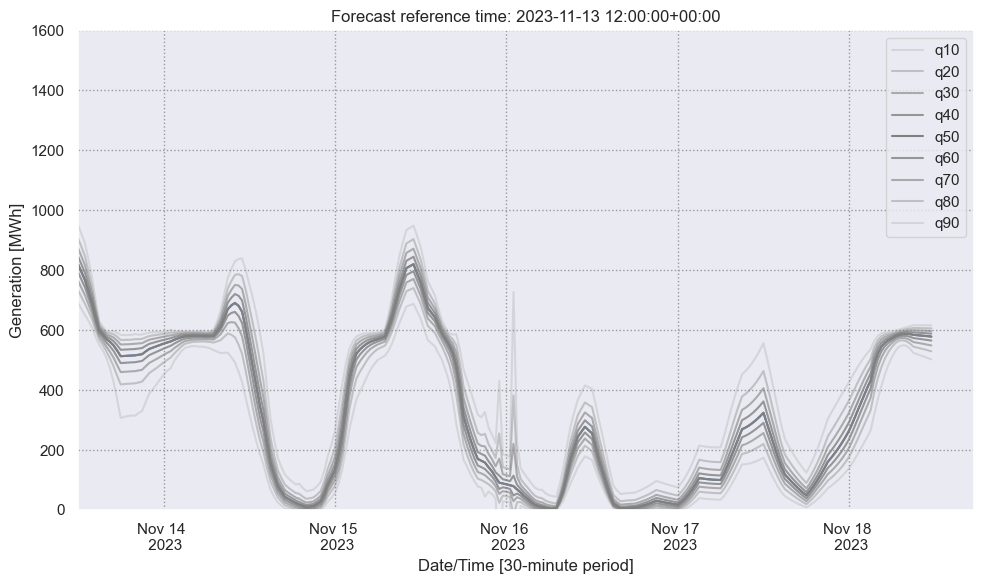

In [19]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
ax1 = sns.lineplot(data=latest_forecast_table, x="valid_datetime",
                   y="q50")

for quantile in range(10,100,10):
    sns.lineplot(data=latest_forecast_table,
                 x=latest_forecast_table["valid_datetime"],
                 y=latest_forecast_table[f"q{quantile}"],
                 color='gray',
                 alpha=1-abs(50-quantile)/50,
                 label=f'q{quantile}')
plt.title(f"Forecast reference time: {latest_forecast_table['ref_datetime'][0]}"
          )
plt.xlabel('Date/Time [30-minute period]')
plt.ylabel('Generation [MWh]')
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %d \n %Y"))
plt.ylim(0, 1600)
plt.xlim(latest_forecast_table['valid_datetime'].min())
plt.tight_layout()
plt.show()

Finally, we need to wrangle our forecast into the correct format the submit
to the competition platform. Some tools are provided in the `comp_utils` module
to help, but you MUST be sure you're submission are correct and take full
responsibility for them.

The day-ahead electricity market in Great Britain is synchronised with the European
market, which runs from midnight to midnight in the CET/CEST timezone. We must submit
bids for each half-hour of this time range. Submissions must be made before
gate closure for the day-ahead market at 9:20am GMT.

The function `comp_utils.day_ahead_market_times()` creates a pandas DataFrame
with the correct timestamps, which handle the transition to and from daylight
saving. (March 31 2024 only contains be 23 hours!!!)

As we are using timezone-aware timestamps, we can make sure to submit the correct
forecasts and bids by merging onto the DataFrame created by `comp_utils.day_ahead_market_times()`.
In this example, our market bid will be equal to our 50% quantile forecast.

The function `comp_utils.prep_submission_in_json_format()` converts out `submission_data`
into the correct format (using column names `datetime`,`q10`,...,`q90` and `market_bid`).

The function `comp_utils.submit()` will send our data to the competition platform and
print the response from the API.

In [11]:
comp_utils.day_ahead_market_times()

DatetimeIndex(['2024-05-18 23:00:00+01:00', '2024-05-18 23:30:00+01:00',
               '2024-05-19 00:00:00+01:00', '2024-05-19 00:30:00+01:00',
               '2024-05-19 01:00:00+01:00', '2024-05-19 01:30:00+01:00',
               '2024-05-19 02:00:00+01:00', '2024-05-19 02:30:00+01:00',
               '2024-05-19 03:00:00+01:00', '2024-05-19 03:30:00+01:00',
               '2024-05-19 04:00:00+01:00', '2024-05-19 04:30:00+01:00',
               '2024-05-19 05:00:00+01:00', '2024-05-19 05:30:00+01:00',
               '2024-05-19 06:00:00+01:00', '2024-05-19 06:30:00+01:00',
               '2024-05-19 07:00:00+01:00', '2024-05-19 07:30:00+01:00',
               '2024-05-19 08:00:00+01:00', '2024-05-19 08:30:00+01:00',
               '2024-05-19 09:00:00+01:00', '2024-05-19 09:30:00+01:00',
               '2024-05-19 10:00:00+01:00', '2024-05-19 10:30:00+01:00',
               '2024-05-19 11:00:00+01:00', '2024-05-19 11:30:00+01:00',
               '2024-05-19 12:00:00+01:00', '2024-0

In [19]:
####### 제출용 #######
# pv_result = np.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\almost_real_test_result\LNN_solar_predict_result_01_13.npy")

# pv_result = np.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\almost_real_test_result\LNN_solar_predict_result_01_16_extend_O.npy")
# pv_result = np.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\almost_real_test_result\LNN_solar_predict_result_01_16_extend_X.npy")

# pv_result = np.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\almost_real_test_result\LNN_solar_predict_result_02_11.npy")
# pv_result = np.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\almost_real_test_result\LNN_solar_predict_result_03_05_extend_O.npy")

# pv_result = np.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\almost_real_test_result\dwd_ncep_merge_case\LNN_solar_predict_result_03_28_extend_O.npy")
pv_result_dwd = np.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\almost_real_test_result\dwd_ncep_merge_case\LNN_solar_predict_result_05_19_extend_O_dwd.npy")
pv_result_ncep = np.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\almost_real_test_result\dwd_ncep_merge_case\LNN_solar_predict_result_05_19_extend_O_ncep.npy")
pv_result_dl = (pv_result_dwd+pv_result_ncep)/2
# pv_result_dl = 0.7*pv_result_dwd+0.3*pv_result_ncep

# pv_result_dl = pv_result_dwd

# wind_result_dl = np.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\almost_real_test_result\dwd_ncep_merge_case\LNN_wind_predict_result_03_28_extend_O.npy")
wind_result_dl_dwd = np.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\almost_real_test_result\dwd_ncep_merge_case\LNN_wind_predict_result_05_19_extend_O_dwd.npy")
wind_result_dl_ncep = np.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\almost_real_test_result\dwd_ncep_merge_case\LNN_wind_predict_result_05_19_extend_O_ncep.npy")
wind_result_dl = (wind_result_dl_dwd+wind_result_dl_ncep)/2
# wind_result_dl = 0.7*wind_result_dl_dwd+0.3*wind_result_dl_ncep

# wind_result_dl = wind_result_dl_dwd

# wind_result_dl = np.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\almost_real_test_result\LNN_wind_predict_result_03_05_extend_O.npy")
# wind_result_ml = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\almost_real_test_result\wind_best_2_slp_lgb_model_q_train_202412_test_2024_0304_0305.csv", index_col=0)

solar_result_ml = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\almost_real_test_result\ML_solar_forecast_output_(dwd_ncep)_slp_using_lgb_model_q_train_202412_test_2024_0518_0519.csv", index_col=0)

pv_result = 0.5*pv_result_dl[0,:,:] + (0.5*solar_result_ml.values).T ## 가중치 앙상블

# wind_result_ml = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\almost_real_test_result\ML_wind_forecast_dwd_ncep_slp_using_lgb_model_q_train_202412_test_2024_0326_0327.csv", index_col=0)
wind_result_ml = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\almost_real_test_result\ML_wind_forecast_output_(dwd_ncep)_slp_using_lgb_model_q_train_202412_test_2024_0518_0519.csv", index_col=0)

# wind_result = (wind_result_dl[0,:,:] + wind_result_ml.values.T)/2 ## 평균 앙상블

wind_result = 0.2*wind_result_dl[0,:,:] + (0.8*wind_result_ml.values).T ## 가중치 앙상블

# wind_result = np.zeros(wind_result_ml.T.shape)
# wind_result[2:7,:] = (0.3*wind_result_dl[0,2:7,:] + 0.7*wind_result_ml.values.T[2:7,:])
# wind_result[:2,:] = (0.9*wind_result_dl[0,:2,:] + 0.1*wind_result_ml.values.T[:2,:])
# wind_result[7:,:] = (0.9*wind_result_dl[0,7:,:] + 0.1*wind_result_ml.values.T[7:,:])

# wind_result = np.zeros(wind_result.shape)+150

# curtailment_value = 342
# time_idx = 20
# wind_result[0,np.where((wind_result[0,:time_idx] > curtailment_value))[0]] = curtailment_value
# wind_result[1,np.where((wind_result[1,:time_idx] > curtailment_value))[0]] = curtailment_value
# wind_result[2,np.where((wind_result[2,:time_idx] > curtailment_value))[0]] = curtailment_value
# wind_result[3,np.where((wind_result[3,:time_idx] > curtailment_value))[0]] = curtailment_value
# wind_result[4,np.where((wind_result[4,:time_idx] > curtailment_value))[0]] = curtailment_value
# wind_result[5,np.where((wind_result[5,:time_idx] > curtailment_value))[0]] = curtailment_value
# wind_result[6,np.where((wind_result[6,:time_idx] > curtailment_value))[0]] = curtailment_value
# wind_result[7,np.where((wind_result[7,:time_idx] > curtailment_value))[0]] = curtailment_value
# wind_result[8,np.where((wind_result[8,:time_idx] > curtailment_value))[0]] = curtailment_value

# curtailment_value_ = 275
# wind_result[:,time_idx:][wind_result[:,time_idx:] > curtailment_value_] = curtailment_value_

curtailment_value_ = 275 # 415
wind_result[0,np.where((wind_result[0,:] > curtailment_value_))[0]] = curtailment_value_
wind_result[1,np.where((wind_result[1,:] > curtailment_value_))[0]] = curtailment_value_
wind_result[2,np.where((wind_result[2,:] > curtailment_value_))[0]] = curtailment_value_
wind_result[3,np.where((wind_result[3,:] > curtailment_value_))[0]] = curtailment_value_
wind_result[4,np.where((wind_result[4,:] > curtailment_value_))[0]] = curtailment_value_
wind_result[5,np.where((wind_result[5,:] > curtailment_value_))[0]] = curtailment_value_
wind_result[6,np.where((wind_result[6,:] > curtailment_value_))[0]] = curtailment_value_
wind_result[7,np.where((wind_result[7,:] > curtailment_value_))[0]] = curtailment_value_
wind_result[8,np.where((wind_result[8,:] > curtailment_value_))[0]] = curtailment_value_


submission_data=pd.DataFrame({"datetime":comp_utils.day_ahead_market_times()})
# day_ahead_market_time = pd.date_range(start="2024-03-30 23:00:00", end="2024-03-31 22:30:00",
#                   freq=pd.Timedelta(30,unit="minute"))
# submission_data=pd.DataFrame({"datetime":day_ahead_market_time})


# submission_data["q10"] = pv_result[0,0,:].T + wind_result.iloc[:,0].values
# submission_data["q20"] = pv_result[0,1,:].T + wind_result.iloc[:,1].values
# submission_data["q30"] = pv_result[0,2,:].T + wind_result.iloc[:,2].values
# submission_data["q40"] = pv_result[0,3,:].T + wind_result.iloc[:,3].values
# submission_data["q50"] = pv_result[0,4,:].T + wind_result.iloc[:,4].values
# submission_data["q60"] = pv_result[0,5,:].T + wind_result.iloc[:,5].values
# submission_data["q70"] = pv_result[0,6,:].T + wind_result.iloc[:,6].values
# submission_data["q80"] = pv_result[0,7,:].T + wind_result.iloc[:,7].values
# submission_data["q90"] = pv_result[0,8,:].T + wind_result.iloc[:,8].values

# cut_end = -2
submission_data["q10"] = pv_result[0,:].T + wind_result[0,:]
submission_data["q20"] = pv_result[1,:].T + wind_result[1,:]
submission_data["q30"] = pv_result[2,:].T + wind_result[2,:]
submission_data["q40"] = pv_result[3,:].T + wind_result[3,:]
submission_data["q50"] = pv_result[4,:].T + wind_result[4,:]
submission_data["q60"] = pv_result[5,:].T + wind_result[5,:]
submission_data["q70"] = pv_result[6,:].T + wind_result[6,:]
submission_data["q80"] = pv_result[7,:].T + wind_result[7,:]
submission_data["q90"] = pv_result[8,:].T + wind_result[8,:]

# submission_data["q10"] = pv_result[0,0,:].T + wind_result[0,:]
# submission_data["q20"] = pv_result[0,1,:].T + wind_result[1,:]
# submission_data["q30"] = pv_result[0,2,:].T + wind_result[2,:]
# submission_data["q40"] = pv_result[0,3,:].T + wind_result[3,:]
# submission_data["q50"] = pv_result[0,4,:].T + wind_result[4,:]
# submission_data["q60"] = pv_result[0,5,:].T + wind_result[5,:]
# submission_data["q70"] = pv_result[0,6,:].T + wind_result[6,:]
# submission_data["q80"] = pv_result[0,7,:].T + wind_result[7,:]
# submission_data["q90"] = pv_result[0,8,:].T + wind_result[8,:]



trading_strategy = np.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\almost_real_test_result\trading_240519.npy")
submission_data["market_bid"] = trading_strategy

# submission_data["market_bid"] = pv_result[0,4,:].T + wind_result[4,:] # submission_data["market_bid"] = pv_result[0,4,:].T + wind_result.iloc[:,4].values
# submission_data["market_bid"] = np.mean((pv_result[0,:,:].T + wind_result.T), axis=1)
# submission_data["market_bid"] = np.mean((pv_result[:,:].T + wind_result.T), axis=1)

submission_data = comp_utils.prep_submission_in_json_format(submission_data)

print(submission_data)

# rebase_api_client.submit(submission_data)

{'market_day': '2024-05-19', 'submission': [{'timestamp': '2024-05-18T23:00:00+01:00', 'market_bid': 187.04895332813123, 'probabilistic_forecast': {10: 81.9435824915141, 20: 119.99637390387653, 30: 153.5819302037287, 40: 169.20357940916136, 50: 194.1609626279562, 60: 210.35047233070065, 70: 228.9969864700649, 80: 250.20669251617883, 90: 275.0}}, {'timestamp': '2024-05-18T23:30:00+01:00', 'market_bid': 170.6858997283259, 'probabilistic_forecast': {10: 80.30772782564796, 20: 112.86652191043723, 30: 138.76916442472057, 40: 153.41711642124247, 50: 174.5377103833748, 60: 193.37410858642338, 70: 202.7616784382077, 80: 220.90043082476973, 90: 259.2386387401092}}, {'timestamp': '2024-05-19T00:00:00+01:00', 'market_bid': 165.7945653271779, 'probabilistic_forecast': {10: 71.58803358914133, 20: 99.46129133405903, 30: 132.3158404767487, 40: 149.2248548572586, 50: 171.057654870289, 60: 192.10615038043034, 70: 204.91652457523355, 80: 221.14100565015812, 90: 250.33973221128238}}, {'timestamp': '2024-

In [20]:
# trading_strategy

In [17]:
# submission_data

In [14]:
submission_data.to_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\almost_real_test_result\hybrid_energy_result_240519.csv")

In [20]:

submission_data=pd.DataFrame({"datetime":comp_utils.day_ahead_market_times()})
submission_data = submission_data.merge(latest_forecast_table,how="left",left_on="datetime",right_on="valid_datetime")
submission_data["market_bid"] = submission_data["q50"]

submission_data = comp_utils.prep_submission_in_json_format(submission_data)
print(submission_data)

rebase_api_client.submit(submission_data)

{'market_day': '2023-11-14', 'submission': [{'timestamp': '2023-11-13T23:00:00+00:00', 'market_bid': 545.8883820300221, 'probabilistic_forecast': {10: 418.3050272820997, 20: 473.3657687491516, 30: 503.3193442334008, 40: 527.0426416547713, 50: 545.8883820300221, 60: 560.8722187195096, 70: 573.0815964973799, 80: 584.0598890167889, 90: 593.7163776082218}}, {'timestamp': '2023-11-13T23:30:00+00:00', 'market_bid': 550.4179924567536, 'probabilistic_forecast': {10: 435.2572958472322, 20: 482.70420545593566, 30: 510.3933090053728, 40: 532.6505405964913, 50: 550.4179924567536, 60: 564.2557736643746, 70: 575.3966657177498, 80: 585.3975275727496, 90: 593.6205129683351}}, {'timestamp': '2023-11-14T00:00:00+00:00', 'market_bid': 554.7014152066549, 'probabilistic_forecast': {10: 450.5254897729113, 20: 491.837564795204, 30: 517.2933593123925, 40: 538.0377216656642, 50: 554.7014152066549, 60: 567.4401183318107, 70: 577.6848505111948, 80: 586.9665435283803, 90: 594.3774114945411}}, {'timestamp': '2023-

## Usage of other API Endpoints

Let's take a look at some of the other API endpoints that provide useful data, e.g. to update our training dataset with recent data, or providing additional data from the electricity market that could inform our trading strategy. Detailed documentation is available on the [IEEE DataPort Page](https://ieee-dataport.org/competitions/hybrid-energy-forecasting-and-trading-competition) and [rebase.energy API docs page](https://api.rebase.energy/challenges/redoc).

Let's grab some historic data and check it matches what we already have from `data/Energy_Data*.csv`...

In [34]:
test_date = "2023-12-28"

rebase_api_client.get_variable(day=test_date,variable="day_ahead_price")

,timestamp_utc,settlement_date,settlement_period,price
0,2023-12-27T23:00:00Z,2023-12-27,47,2.28
1,2023-12-27T23:30:00Z,2023-12-27,48,2.28
2,2023-12-28T00:00:00Z,2023-12-28,1,0.08
3,2023-12-28T00:30:00Z,2023-12-28,2,0.08
4,2023-12-28T01:00:00Z,2023-12-28,3,-0.57
5,2023-12-28T01:30:00Z,2023-12-28,4,-0.57
6,2023-12-28T02:00:00Z,2023-12-28,5,-1.10
7,2023-12-28T02:30:00Z,2023-12-28,6,-1.10
8,2023-12-28T03:00:00Z,2023-12-28,7,-0.72
9,2023-12-28T03:30:00Z,2023-12-28,8,-0.72


In [31]:
test_date = "2024-01-02"
rebase_api_client.get_variable(day=test_date,variable="imbalance_price")
# rebase_api_client.get_variable(day=test_date,variable="wind_total_production").head()
# rebase_api_client.get_variable(day=test_date,variable="solar_total_production").head()

,timestamp_utc,settlement_date,settlement_period,imbalance_price
0,2024-01-02T00:00:00Z,2024-01-02,1,-46.32000
1,2024-01-02T00:30:00Z,2024-01-02,2,-44.76000
2,2024-01-02T01:00:00Z,2024-01-02,3,-31.00000
3,2024-01-02T01:30:00Z,2024-01-02,4,-44.76000
4,2024-01-02T02:00:00Z,2024-01-02,5,-44.76000
5,2024-01-02T02:30:00Z,2024-01-02,6,-29.56000
6,2024-01-02T03:00:00Z,2024-01-02,7,-29.56000
7,2024-01-02T03:30:00Z,2024-01-02,8,-29.56000
8,2024-01-02T04:00:00Z,2024-01-02,9,-29.56000
9,2024-01-02T04:30:00Z,2024-01-02,10,-29.56000


In [23]:
energy_data.loc[
    (energy_data["dtm"] >= pd.to_datetime(test_date).tz_localize("Europe/Paris")) &
    (energy_data["dtm"] < pd.to_datetime(test_date).tz_localize("Europe/Paris") + pd.Timedelta(1,unit="day"))
    ]

,dtm,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price,Wind_MWh_credit,Solar_MWh_credit
45932,2023-05-04 22:00:00+00:00,75.61,0.000000,2311.905174,2458.131803,1186.204,75.61000,0.0,74.21,593.102,0.000000
45933,2023-05-04 22:30:00+00:00,71.64,0.000000,2311.905174,2458.131803,1181.626,71.64000,0.0,74.21,590.813,0.000000
45934,2023-05-04 23:00:00+00:00,77.65,0.000000,2311.904851,2458.131803,1180.024,109.00000,0.0,73.71,590.012,0.000000
45935,2023-05-04 23:30:00+00:00,77.81,0.000000,2311.904851,2458.131803,1164.262,109.00000,0.0,73.71,582.131,0.000000
45936,2023-05-05 00:00:00+00:00,78.13,0.000000,2311.904851,2458.131803,1122.384,105.00000,0.0,71.36,561.192,0.000000
45937,2023-05-05 00:30:00+00:00,78.65,0.000000,2311.904851,2458.131803,1005.864,78.65000,0.0,71.36,502.932,0.000000
45938,2023-05-05 01:00:00+00:00,68.93,0.000000,2311.904851,2458.131803,697.086,68.93000,0.0,71.60,348.543,0.000000
45939,2023-05-05 01:30:00+00:00,69.50,0.000000,2311.904851,2458.131803,490.244,69.50000,0.0,71.60,245.122,0.000000
45940,2023-05-05 02:00:00+00:00,66.81,0.000000,2311.904851,2458.131803,395.524,66.81000,0.0,78.97,197.762,0.000000
45941,2023-05-05 02:30:00+00:00,67.65,0.000000,2311.904851,2458.131803,322.684,67.65000,0.0,78.97,161.342,0.000000
